## 이 노드의 루브릭       

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.       
: 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.   


2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.      
: U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.         


3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.             
: 10Epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞는 품질을 확인하였다.

---
## 프로젝트 수행        

__필수 수행 요건__        

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.      
2. U-Net Generator를 사용해주세요.        
3. 모델 학습 후, val 폴더 내 이미지로 테스트를 진행하세요.      
4. 1개 이상의 이미지에 대해 테스트를 거친 후, 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화 해 주세요.      
5. 10Epoch 이상의 학습을 수행하고, 중간 손실 값에 대한 로그를 남겨주세요.

---           
## 목차             

1. 데이터 로드하기       
2. 데이터 전처리하기      
3. Generator 구성하기         
4. Discriminator 구성하기        
5. 학습하기      
6. 테스트하기

## 1. 데이터 로드하기          

- 다음과 같은 city 사진을 이용해 pix2pix를 활용한 도로 사진을 생성해보자.       

![데이터셋사진](./PostingPic/데이터셋사진.png)

In [12]:
import os

data_path = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes'
train_path = data_path + '/train' 
val_path = data_path + '/val'

print('데이터 경로 : ', data_path)
print('학습 데이터 수 : ' , len(list(os.listdir(train_path))))
print('검증 데이터 수 : ' , len(list(os.listdir(val_path))))

데이터 경로 :  /home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes
학습 데이터 수 :  1000
검증 데이터 수 :  5


#### 데이터 확인하기 

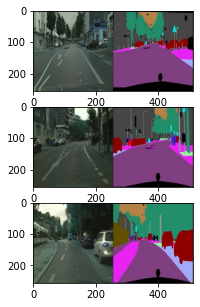

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

for i in range(1, 4):
    f = train_path + "/" +os.listdir(train_path)[np.random.randint(500)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,1,i)
    plt.imshow(img)

> 데이터를 시각화하여 확인하였다.    
> 단, 위의 데이터를 보면 실제 도로 사진과 세그멘테이션 된 도로 사진이 존재하므로, 
위의 사진을 절반 잘라 분리하여야 함을 알 수 있다.

#### 자르기 위해 데이터셋 이미지 크기 확인

In [23]:
f = train_path + "/" + os.listdir(train_path)[0]

img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


> 256*512 사이즈의 컬러(3채널) 이미지임을 확인하였고, 가로 너비를 절반 잘라     
> 색깔로 표시된 부분을 input으로 넣어 왼쪽 실사 도로사진 output을 얻겠다.

In [24]:
#필요한 함수 세팅
import tensorflow as tf

#컬러 채널을 노말라이즈
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) -1

#노말라이즈된 채널을 다시 복원
def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

#이미지를 리얼/컬러로 나누어서 노말라이징하여 반환
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1]//2
    real = img[:, :w, :]
    real = tf.cast(real, tf.float32)
    
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    
    return normalize(real), normalize(colored)

/home/ssac23/SUBMIT_MISSION_GIT/ex20_NEWGAN/cityscapes/train/462.jpg


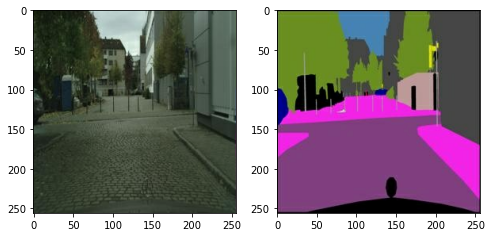

In [29]:
#실제 train_path를 활용하여 하나의 이미지만 절반 잘라보기
f = train_path + "/" + os.listdir(train_path)[1]
real, colored = load_image(f)

plt.figure(figsize=(8,5))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

> 잘 잘라졌음을 확인하였다!

### 조건 1. Augmentation 적용하기

In [42]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(real, colored):
    stacked = tf.concat([real, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    if tf.random.uniform(())<.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
        
    #가로세로(256,512,3)이었던 그림을 절반으로 잘랐기 때문에
    #가로세로(256,256,3)의 그림으로 바뀌었고, 이것을 크롭한다.
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
        
    #아까 합쳐두었던 real과 colored를 다시 3채널 3채널로 나누어 반환
    return out[..., :3], out[..., 3:]

##### 이미지에 augmentation를 적용하여 시각화 해 보자.

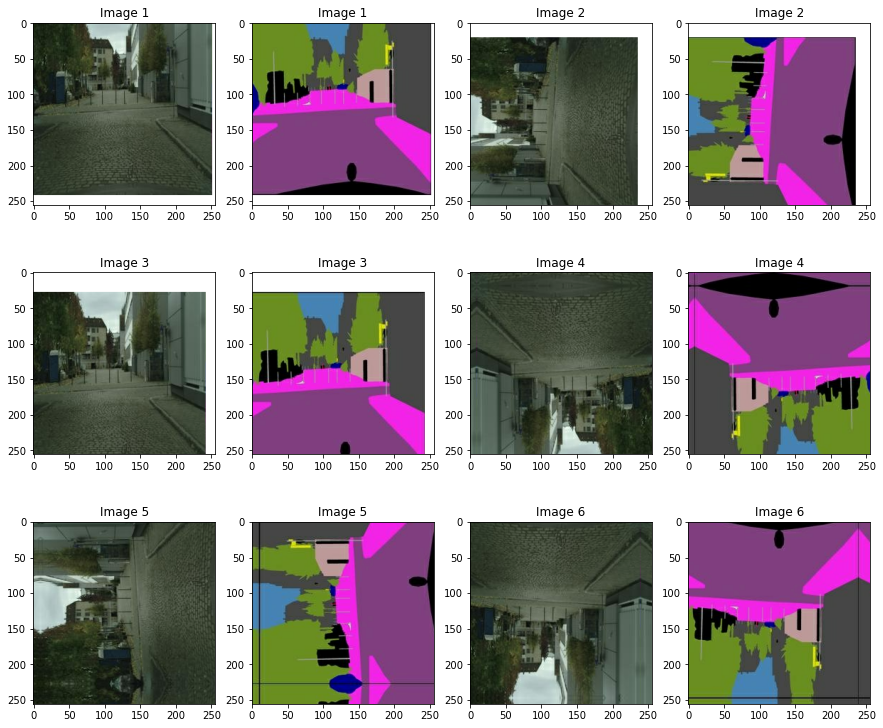

In [43]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_real, augmented_colored = apply_augmentation(real, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1                               

> 이미지에 다양한 augmentation 기법을 적용하였음을 확인하였다.